In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 7.16.1

numpy 1.19.1
pandas 1.1.1
torch 1.4.0
transformers 3.1.0


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import time
import datetime

import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Examine the data

In [5]:
# https://www.kaggle.com/kazanova/sentiment140
column_names = ["target", "ids", "date", "flag","user","text"]
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv", names=column_names, header=None, encoding="ISO-8859-1")

In [6]:
print(f'\nShape: {df.shape}\n')
df.head()


Shape: (1600000, 6)



,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Subsample from dataset that's too big for now

In [7]:
print(f'Before: {df.shape[0]} samples')
df =  df.sample(n=100000, random_state=RANDOM_SEED)
print(f'After: {df.shape[0]} samples')

Before: 1600000 samples
After: 100000 samples


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 541200 to 429504
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  100000 non-null  int64 
 1   ids     100000 non-null  int64 
 2   date    100000 non-null  object
 3   flag    100000 non-null  object
 4   user    100000 non-null  object
 5   text    100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB



0 is negative, 4 is positive



<AxesSubplot:xlabel='target', ylabel='count'>

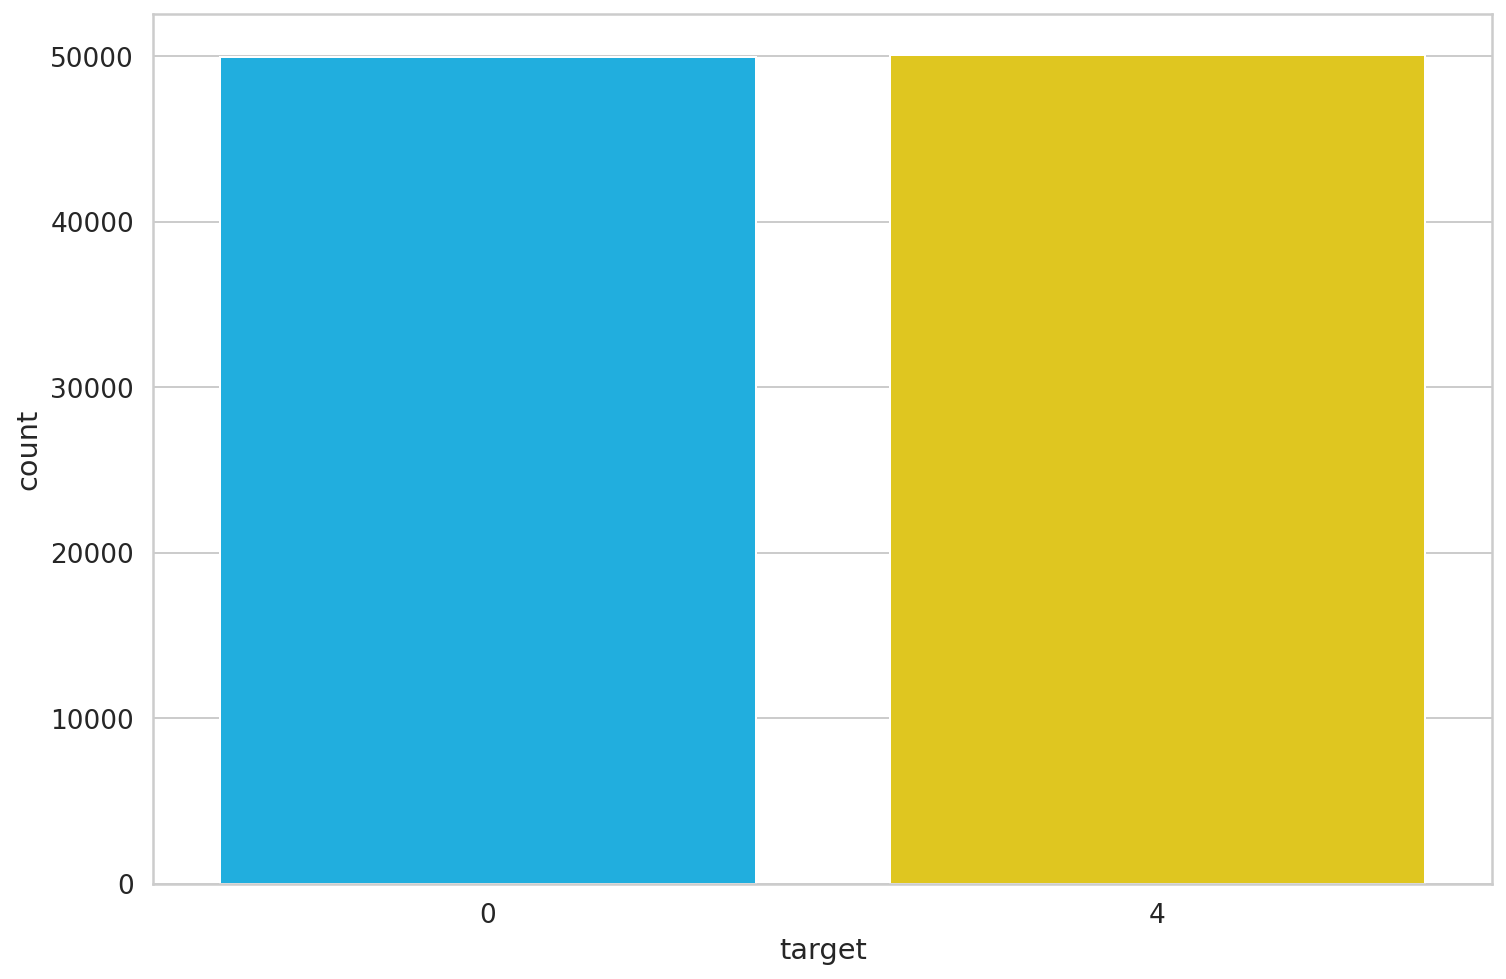

In [9]:
print(f'\n{0} is negative, {4} is positive\n')
sns.countplot(df.target)

#### Change the label "4" to "1"

In [10]:
df.target[df.target==4] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.



0 is negative, 1 is positive



<AxesSubplot:xlabel='target', ylabel='count'>

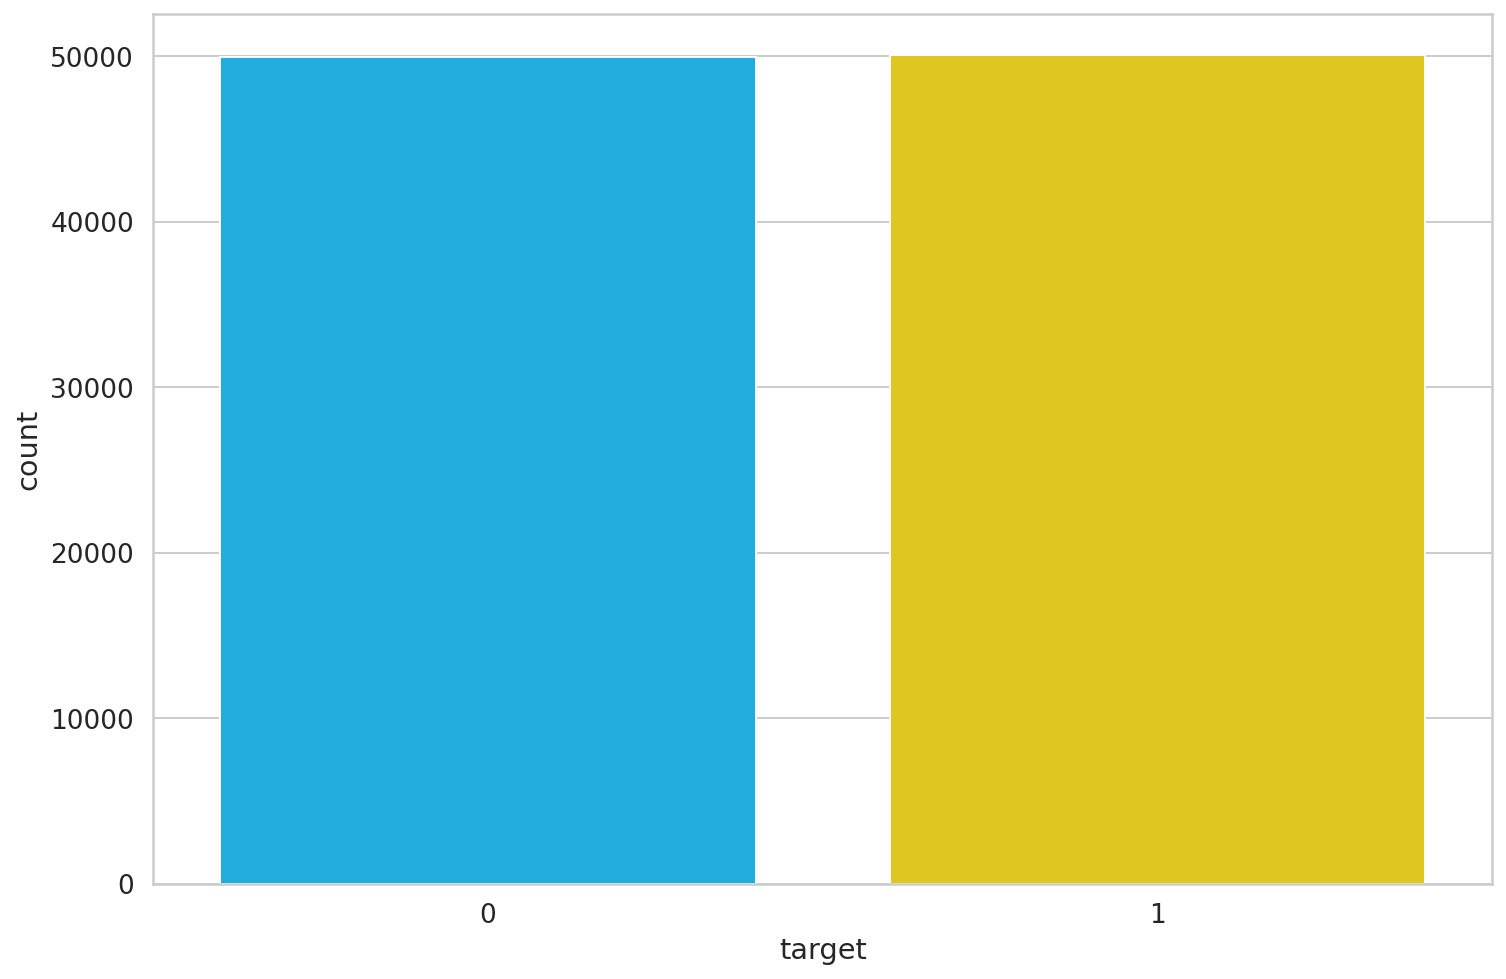

In [11]:
print(f'\n{0} is negative, {1} is positive\n')
sns.countplot(df.target)

In [12]:
class_names = ['negative', 'positive']

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_PATH = "models/bert-base-cased/"

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Tokenization converts text to tokens for specific model. bert-base-cased model doesn't ignore the case of text, for example

In [15]:
sample_txt = "I wish I could go outside but some jerks aren't wearing masks and prolonging this whole thing"

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_txt}\nTokens: {tokens}\nToken IDs: {token_ids}')

Sentence: I wish I could go outside but some jerks aren't wearing masks and prolonging this whole thing
Tokens: ['I', 'wish', 'I', 'could', 'go', 'outside', 'but', 'some', 'jerk', '##s', 'aren', "'", 't', 'wearing', 'masks', 'and', 'pro', '##long', '##ing', 'this', 'whole', 'thing']
Token IDs: [146, 3683, 146, 1180, 1301, 1796, 1133, 1199, 12935, 1116, 4597, 112, 189, 3351, 17944, 1105, 5250, 9851, 1158, 1142, 2006, 1645]


### Some tokens can be added manually to tell BERT what to do 

In [17]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

### The [CLS] Token needs to be added to the start of each sentence to do classification

In [18]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

### [PAD] is a token for padding

In [19]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

### Tokens not in the training set will be encoded using the unknown [UNK] token

In [20]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### the encode_plus() method does all the necessary encoding

In [21]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

encoding.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  3683,   146,  1180,  1301,  1796,  1133,  1199, 12935,
         1116,  4597,   112,   189,  3351, 17944,  1105,  5250,  9851,  1158,
         1142,  2006,  1645,   102,     0,     0,     0,     0,     0,     0,
            0,     0])

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'wish',
 'I',
 'could',
 'go',
 'outside',
 'but',
 'some',
 'jerk',
 '##s',
 'aren',
 "'",
 't',
 'wearing',
 'masks',
 'and',
 'pro',
 '##long',
 '##ing',
 'this',
 'whole',
 'thing',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing sequence length - figure out the size of the sequence which we should set

In [25]:
# token_lens = []
# for index, txt in df.text.items():
#     if (index % 100000) == 0:
#         print(f'{index}/{df.text.size}')
#     tokens = tokenizer.encode(txt, max_length=280, truncation=True)
#     token_lens.append(len(tokens))

In [26]:
# sns.distplot(token_lens)
# plt.xlim([0,120])
# plt.xlabel('Token Count')

### Twitter posts seem to have a max of about 70 tokens, we'll make the max 70.

In [27]:
MAX_LEN = 70

In [28]:
class TwitterDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweets = str(self.tweets[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
          tweets,
          add_special_tokens=True,
          max_length=self.max_len,
          truncation = True,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        return {
          'tweets_text': tweets,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

### Separate data into train/test/validation sets (90/5/5)

In [29]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [30]:
df_train.shape, df_val.shape, df_test.shape

((90000, 6), (5000, 6), (5000, 6))

### Training data loader

In [31]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TwitterDataset(
        tweets=df.text.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

BATCH_SIZE=16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


### Check out an example batch:

In [32]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweets_text', 'input_ids', 'attention_mask', 'targets'])

In [33]:
print(f"{data['input_ids'].shape}\n{data['attention_mask'].shape}\n{data['targets'].shape}")


torch.Size([16, 70])
torch.Size([16, 70])
torch.Size([16])


## Load up the BERT model!

In [34]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_PATH)


#### Use the model on the example text

In [35]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [36]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [37]:
bert_model.config.hidden_size

768

In [38]:
pooled_output.shape

torch.Size([1, 768])

In [39]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_PATH)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [40]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [41]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 70])
torch.Size([16, 70])


In [42]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.8008, 0.1992],
        [0.6625, 0.3375],
        [0.6821, 0.3179],
        [0.7899, 0.2101],
        [0.7650, 0.2350],
        [0.7860, 0.2140],
        [0.7566, 0.2434],
        [0.7612, 0.2388],
        [0.5935, 0.4065],
        [0.6880, 0.3120],
        [0.6956, 0.3044],
        [0.6968, 0.3032],
        [0.6653, 0.3347],
        [0.7168, 0.2832],
        [0.6027, 0.3973],
        [0.7710, 0.2290]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training

In [43]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [44]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    total_batches = len(data_loader)
    start = time.time()
    for i, d in enumerate(data_loader):
#         sys.stdout.flush()
#         sys.stdout.write(f'\r{i}/{total_batches}')
        progress_bar(i, total_batches)
        if i == 9:
            end = time.time()
#             sys.stdout.flush()
            epoch_time = datetime.timedelta(seconds = np.round((end-start) / 10 * total_batches))
            print(f'Time until epoch finishes: {epoch_time}            ')
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [46]:
def progress_bar(current, total, bar_length=20):
    percent = float(current) * 100 / total
    arrow = '-' * int(percent/100 * bar_length - 1) + '>'
    spaces = ' '  * (bar_length - len(arrow))
    print(f'Progress: [{arrow}{spaces}] {percent:.1f}%', end='\r')

In [47]:
model.load_state_dict(torch.load('models/best_model_state.bin'))
best_accuracy = 0
val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
)
print(f'Val   loss {val_loss} accuracy {val_acc}')
best_accuracy = val_acc

Val   loss 0.37851528637706283 accuracy 0.8336


In [48]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'models/best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Time until epoch finishes: 0:10:35            
Train loss 0.2561473218235705 accuracy 0.9040444444444445
Val   loss 0.5487331764790387 accuracy 0.8294

Epoch 2/10
----------
Time until epoch finishes: 0:10:44            
Train loss 0.2391845488342974 accuracy 0.9184222222222223
Val   loss 0.5707559111102606 accuracy 0.8270000000000001

Epoch 3/10
----------
Time until epoch finishes: 0:10:35            


KeyboardInterrupt: 

(0.0, 1.0)

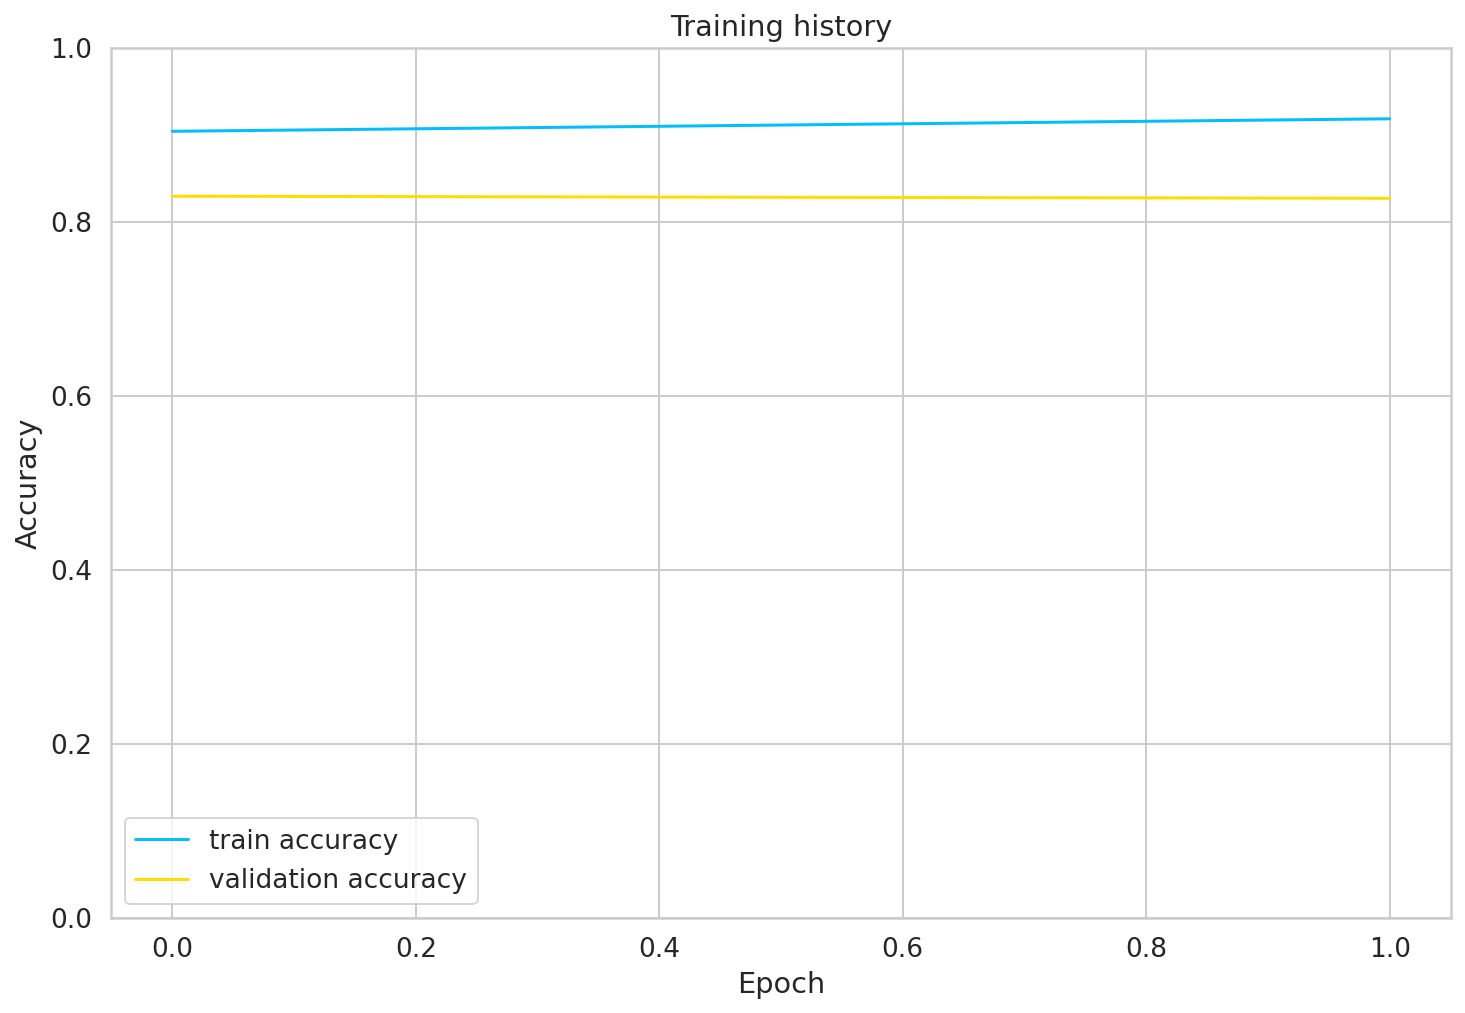

In [53]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])

## I trained it i'm a miracle worker. Evaluation time!

In [54]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

print(f'Test Accuracy: {test_acc.item()*100:.2f}')

Test Accuracy: 82.54


In [61]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            
            texts = d['tweets_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweet_texts, predictions, prediction_probs, real_values

In [62]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [63]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.86      0.78      0.82      2553
    positive       0.79      0.87      0.83      2447

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



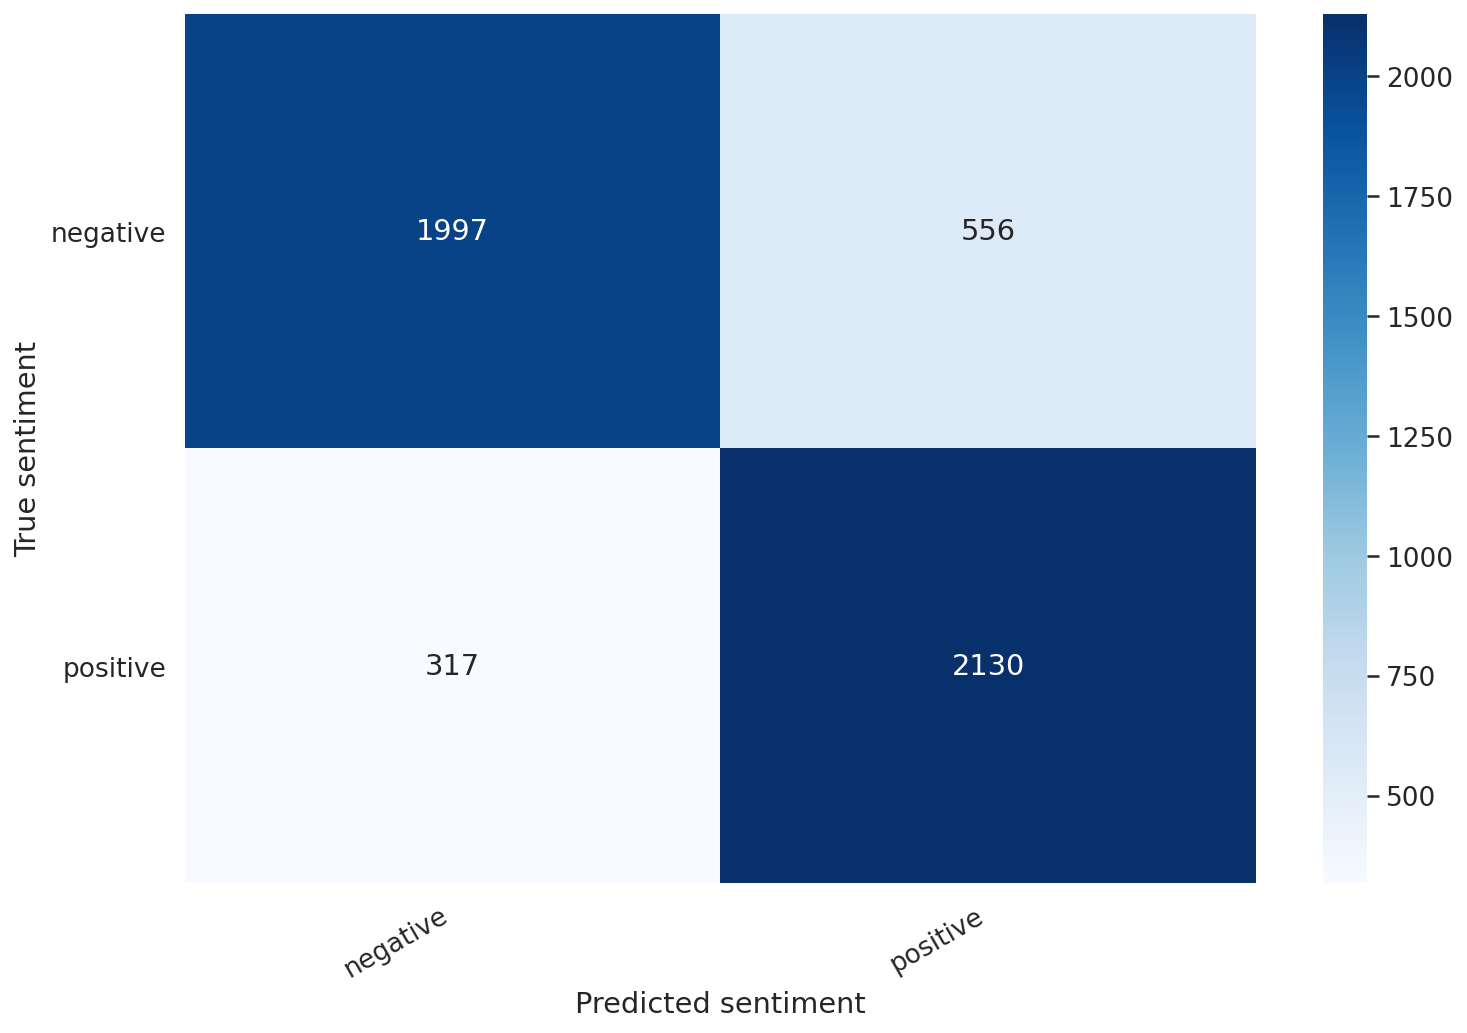

In [64]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [66]:
idx = 2
tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [67]:
print("\n".join(wrap(tweet_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

living MY American Dream

True sentiment: positive


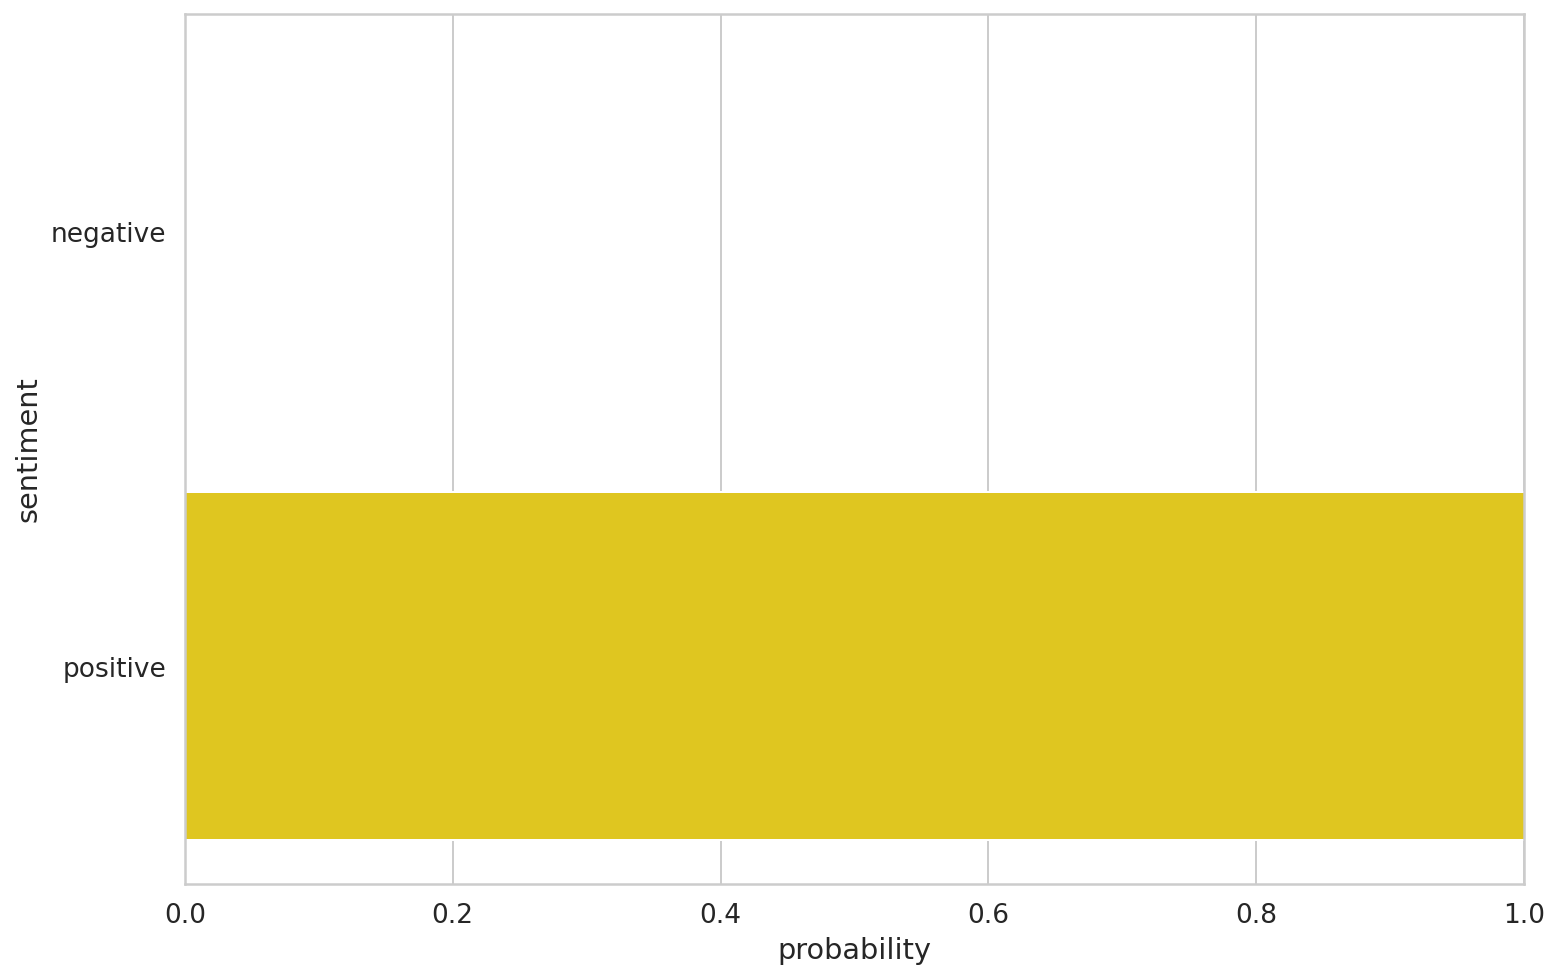

In [68]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);